<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/week2/part1/2_07_Routing_ReAct_Streaming_LangSmith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LangChain v1.0 — Ejemplos para clase (Routing, ReAct Agents, Streaming y LangSmith)

Este notebook contiene **ejemplos** de:

- **Routing**: decidir automáticamente qué cadena ejecutar según la intención del usuario.
- **ReAct Agents**: agente que razona y usa herramientas (tool calling) en varios pasos.
- **Streaming**: ver la salida del modelo en tiempo real.
- **LangSmith**: trazabilidad y observabilidad (traces) para depurar y evaluar.


In [1]:
# === 0) Configuración: claves y entorno ===
# En Colab, puedes guardar tu API Key en: Runtime -> Secrets (userdata)
from google.colab import userdata
import os

# Gemini (Google AI Studio) API Key
# - En Colab: agrega un secret llamado "GOOGLE_API_KEY"
# - En local: exporta GOOGLE_API_KEY en tu sistema
if "GOOGLE_API_KEY" not in os.environ:
    try:
        os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
    except Exception:
        pass

print("GOOGLE_API_KEY configurada:", "✅" if os.getenv("GOOGLE_API_KEY") else "⚠️ (no encontrada)")


GOOGLE_API_KEY configurada: ✅


In [2]:
# === 1) Instalación de dependencias ===
!pip -q install "langchain>=1,<2" langchain-core langchain-community langchain-text-splitters
!pip -q install langchain-google-genai
!pip -q install langsmith


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.0 MB/s eta 0:00:00


In [3]:
# === 2) Modelo base (Gemini via langchain-google-genai) ===
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.2,
    max_output_tokens=32,
)

print("✅ Modelo listo:", llm.model)


✅ Modelo listo: gemini-2.0-flash


También se puede probar usando groq

In [4]:
!pip -q install -U langchain-groq

from google.colab import userdata
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")  # crea este secret en Colab

print("GROQ_API_KEY configurada:", "✅" if os.getenv("GROQ_API_KEY") else "⚠️")


from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2,
)

print("✅ Modelo Groq listo:", llm.model_name)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 3.9 MB/s eta 0:00:00
GROQ_API_KEY configurada: ✅
✅ Modelo Groq listo: llama-3.1-8b-instant


## 1) Routing en LangChain (LCEL)

La idea es tener **una entrada** (pregunta del usuario) y decidir **qué pipeline ejecutar**.

En este ejemplo vamos a enrutar entre:
- una cadena de **explicación conceptual**
- una cadena de **código en Python**

La decisión la tomará el modelo con una salida estructurada (Pydantic) y luego ejecutaremos un `RunnableBranch`.


In [31]:
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableBranch
from langchain_core.output_parsers import StrOutputParser

class RouteDecision(BaseModel):
    route: Literal["explicacion", "codigo"] = Field(
        description="Ruta a ejecutar: 'explicacion' o 'codigo'."
    )
    reason: str = Field(description="Breve razón de por qué eliges esa ruta.")

router_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Eres un router. Tu tarea es clasificar la intención del usuario."
     "Elige:"
     "- 'explicacion' si el usuario pide explicación, resumen o concepto."
     "- 'codigo' si el usuario pide ejemplo, snippet, implementación o código."
     "Responde SOLO con el JSON del esquema pedido."),
    ("user", "Consulta: {question}")
])

# 1) El LLM devuelve un objeto RouteDecision (salida estructurada)
router_chain = router_prompt | llm.with_structured_output(RouteDecision)

# 2) Definimos dos cadenas destino
exp_prompt = ChatPromptTemplate.from_messages([
    ("system", "Eres profesor. Explica claro, corto y con un ejemplo simple."),
    ("user", "{question}")
])
exp_chain = exp_prompt | llm | StrOutputParser()

code_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Eres un ingeniero. Responde con un ejemplo en Python y una explicación breve."
     "Reglas:"
     "- Usa Python 3"
     "- Incluye un bloque de código"
     "- Manténlo simple"),
    ("user", "{question}")
])
code_chain = code_prompt | llm | StrOutputParser()

# 3) Branch: elige la cadena según route
branch = RunnableBranch(
    (lambda x: x["route"] == "explicacion", exp_chain),
    (lambda x: x["route"] == "codigo", code_chain),
    exp_chain,  # default
)

# 4) Pipeline final: clasificamos y luego ejecutamos la rama
routing_pipeline = (
    RunnableLambda(lambda x: {"question": x["question"]})  # normalizamos entrada
    | RunnableLambda(lambda x: {
        "question": x["question"],
        "decision": router_chain.invoke({"question": x["question"]})
    })
    | RunnableLambda(lambda x: {
        "question": x["question"],
        "route": x["decision"].route,
        "reason": x["decision"].reason
    })
    | branch
)

print("✅ Routing pipeline listo")


✅ Routing pipeline listo


In [32]:
# Prueba 1: pregunta conceptual -> debería ir por 'explicacion'
print(routing_pipeline.invoke({"question": "Explícame qué es un embedding y para qué sirve."}))


Un embedding (también conocido como vector de representación) es una técnica de procesamiento de lenguaje natural que permite representar palabras o tokens como vectores numéricos en un espacio multidimensional.

**¿Por qué necesitamos embeddings?**

Cuando trabajamos con lenguaje natural, las palabras tienen significados y relaciones entre sí que no se pueden capturar con simples cadenas de texto. Los embeddings permiten a los modelos de aprendizaje automático capturar estas relaciones y representar las palabras de manera más rica y significativa.

**Ejemplo simple**

Imagina que tenemos un modelo de clasificación de textos que debe determinar si un texto es positivo o negativo. Sin embeddings, el modelo solo vería las palabras como cadenas de texto y no podría capturar la relación entre ellas.

Con embeddings, el modelo puede representar cada palabra como un vector numérico en un espacio de 100 dimensiones, por ejemplo. Cada palabra tiene un vector único que la representa de manera m

In [26]:
# Prueba 2: pide implementación -> debería ir por 'codigo'
print(routing_pipeline.invoke({"question": "Dame un ejemplo en Python para calcular TF-IDF de una lista de textos."}))


**TF-IDF en Python**

TF-IDF (Term Frequency-Inverse Document Frequency) es un algoritmo utilizado en el procesamiento de lenguaje natural para calcular la importancia de cada palabra en un conjunto de documentos.

Aquí te muestro un ejemplo de cómo calcular TF-IDF en Python utilizando la biblioteca `scikit-learn` y `numpy`:

```python
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Listado de textos
textos = [
    "Este es un ejemplo de texto.",
    "Este texto es un ejemplo.",
    "El ejemplo es un texto.",
    "Este texto es un ejemplo de texto."
]

# Crear un objeto TfidfVectorizer
vectorizador = TfidfVectorizer()

# Convertir los textos en matrices de TF-IDF
matriz_tfidf = vectorizador.fit_transform(textos)

# Calcular la similitud entre los textos
similitud = cosine_similarity(matriz_tfidf)

# Mostrar la matriz de similitud
print(similitud)
```

En este ejemplo, se crea un objeto `TfidfVector

## 2) ReAct Agents en LangChain

**ReAct** combina: *razonamiento* + *acciones*.

En la práctica: el agente recibe una tarea, decide si necesita una herramienta (tool), la ejecuta, observa el resultado y continúa.

En LangChain 1.0, podemos crear un agente con `create_agent` y exponer herramientas con el decorador `@tool`.


In [33]:
from langchain_core.tools import tool
from langchain.agents import create_agent
from datetime import datetime

@tool
def calculadora(expr: str) -> str:
    """Evalúa una expresión matemática simple (ej: '23*17 + 5')."""
    # WARNING: eval es solo para demo controlada. No usar así en producción.
    allowed = set("0123456789+-*/(). %")
    if any(ch not in allowed for ch in expr):
        return "Expresión no permitida (solo números y + - * / ( ) % .)."
    try:
        return str(eval(expr))
    except Exception as e:
        return f"Error evaluando: {e}"

@tool
def hora_actual() -> str:
    """Devuelve la fecha y hora actual en formato ISO (demo)."""
    return datetime.now().isoformat(timespec="seconds")

SYSTEM_PROMPT = """
Eres un agente ReAct (Reason + Act) para demos de LangChain. Tu objetivo es resolver la solicitud del usuario
de forma correcta, breve y segura, usando herramientas cuando aporten valor.

## Herramientas disponibles
- calculadora(expr): Úsala para cualquier operación matemática, porcentajes, divisiones, reglas de tres, etc.
- hora_actual(): Úsala solo si el usuario pide explícitamente la hora/fecha o si es necesaria para responder.

## Política de uso de herramientas
1) Si hay CÁLCULO: usa calculadora. No “adivines” números.
2) Si hay HORA/FECHA: usa hora_actual.
3) Si el usuario pide varias cosas, resuélvelas en orden lógico (primero cálculos, luego la parte explicativa).
4) Si una herramienta falla o devuelve error, intenta una vez más corrigiendo el input. Si vuelve a fallar, explica
   el problema y ofrece alternativa.

## Razonamiento y trazabilidad (estilo ReAct)
- Piensa internamente (no muestres tu cadena de pensamiento).
- Actúa con herramientas solo cuando se necesite.
- Tras usar herramientas, valida que el resultado sea coherente (ej: signos, magnitudes, unidades).
- Si el usuario no especifica datos críticos, pide lo mínimo necesario o asume explícitamente y di la suposición.

## Formato de respuesta final (OBLIGATORIO)
Entrega SIEMPRE:
- ✅ Respuesta final

Si aplica, agrega:
- 🧮 Cálculo (resultado principal)
- 🕒 Hora/fecha (si se pidió)
- 📝 Nota breve (1-2 líneas máximo) con contexto o interpretación

## Estilo
- Español claro, directo, sin relleno.
- No muestres instrucciones internas ni menciones “ReAct”.
- No incluyas código a menos que el usuario lo pida.
"""


agent = create_agent(
    model=llm,
    tools=[calculadora, hora_actual],
    system_prompt=SYSTEM_PROMPT,
)

print("✅ Agente ReAct listo")


✅ Agente ReAct listo


In [34]:
# Demo: el agente debería usar tools
result = agent.invoke({
    "messages": [
        {"role": "user", "content": "¿Cuánto es 23*17? y además dime la hora actual."}
    ]
})
print(result["messages"][-1].content)


✅ 391
🕒 2026-02-14T15:50:35


## 3) Streaming

El **streaming** permite mostrar la salida *token a token* (o chunk a chunk) mientras el modelo responde.

En LangChain, muchas cadenas soportan `.stream()`.

Aquí haremos streaming sobre una cadena simple (prompt → modelo → parser).


In [35]:
import sys
from langchain_core.prompts import ChatPromptTemplate

stream_prompt = ChatPromptTemplate.from_messages([
    ("system", "Responde en español y de forma breve."),
    ("user", "Resume el siguiente tema: {topic}")
])

stream_chain = stream_prompt | llm

print("✅ Cadena con streaming lista\n")

✅ Cadena con streaming lista



In [36]:
# Streaming: chunk a chunk del modelo
for chunk in stream_chain.stream({"topic": "qué es LangChain y para qué se usa"}):
    # chunk suele ser un AIMessageChunk con .content
    text = getattr(chunk, "content", None)
    if text:
        sys.stdout.write(text)
        sys.stdout.flush()

LangChain es una plataforma de inteligencia artificial (IA) que permite la creación de modelos de lenguaje avanzados y la integración de diferentes tecnologías de IA. Se utiliza para:

- Desarrollar modelos de lenguaje que puedan aprender y mejorar con el tiempo.
- Integrar diferentes fuentes de información y datos para tomar decisiones informadas.
- Crear aplicaciones de IA que puedan interactuar con usuarios de manera natural.
- Automatizar tareas y procesos que requieren análisis de lenguaje y comprensión de contexto.

En resumen, LangChain es una herramienta poderosa para desarrollar aplicaciones de IA que puedan aprender, mejorar y interactuar con usuarios de manera efectiva.

## 4) LangSmith (tracing / observabilidad)

LangSmith te ayuda a:
- ver **traces** (paso a paso) de cadenas y agentes
- depurar prompts/herramientas
- registrar evaluaciones y feedback

Para activarlo, normalmente configuras estas variables de entorno:

- `LANGCHAIN_TRACING_V2=true`
- `LANGCHAIN_API_KEY=...`
- `LANGCHAIN_PROJECT=...` (opcional)

En Colab, puedes guardar un secret `LANGCHAIN_API_KEY`.


In [28]:
from google.colab import userdata
import os

# 1) API KEY: acepta cualquiera de los dos nombres de secret
key = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = key

# 2) Endpoint correcto de LangSmith (importante)
os.environ.setdefault("LANGCHAIN_ENDPOINT", "https://api.smith.langchain.com")

# 3) Activar tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ.setdefault("LANGCHAIN_PROJECT", "oe-course")
os.environ["LANGCHAIN_PROJECT"] = "oe-course"

print("LANGCHAIN_API_KEY:", "✅" if os.getenv("LANGCHAIN_API_KEY") else "⚠️ (falta)")
print("LANGCHAIN_ENDPOINT:", os.getenv("LANGCHAIN_ENDPOINT"))
print("LANGCHAIN_TRACING_V2:", os.getenv("LANGCHAIN_TRACING_V2"))
print("LANGCHAIN_PROJECT:", os.getenv("LANGCHAIN_PROJECT"))


LANGCHAIN_API_KEY: ✅
LANGCHAIN_ENDPOINT: https://api.smith.langchain.com
LANGCHAIN_TRACING_V2: true
LANGCHAIN_PROJECT: oe-course


In [37]:
from langchain_core.tracers.context import tracing_v2_enabled

with tracing_v2_enabled(project_name=os.getenv("LANGCHAIN_PROJECT", "oe-course")):
    _ = stream_chain.invoke({"topic": "diferencia entre chain y agent en LangChain"})

Al ejecutar este código, la traza se ve en LangSmith de la siguiente forma:

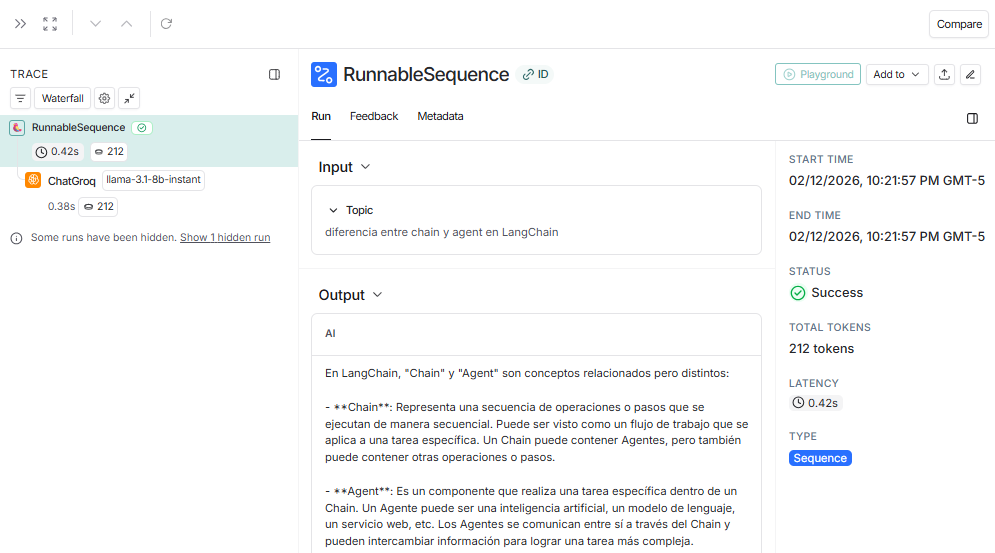

---